# Preparing NIfTI data for connectivity analysis

All connectivity methods require 2D time series data as an input. Hereby, it does not matter if this is parcellated data (ROI level) or still on the scale of individual voxels.

Here, we will showcase a standard Pythonic `nilearn` workflow for loading, cleaning, and parcellating some data. Then, we will use the Comet toolbox to estimate dynamic functional connectivity.

Time series shape: (176, 69681)


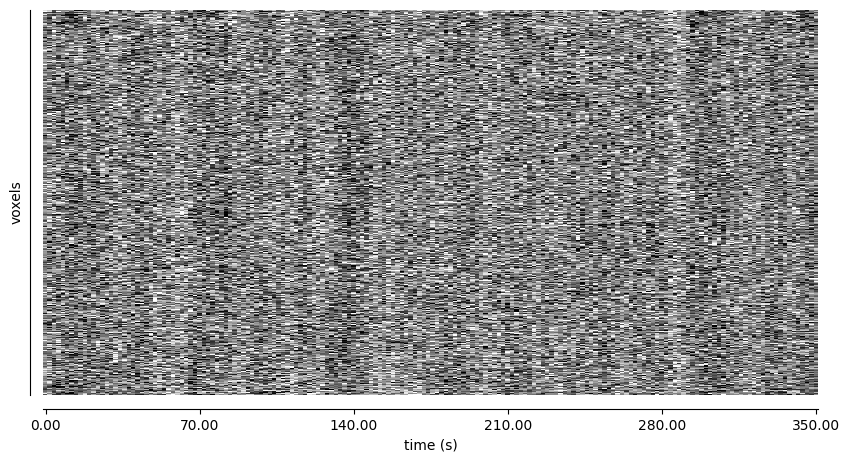

In [ ]:
from nilearn import datasets, maskers, plotting

# Download data
adhd_data = datasets.fetch_adhd(data_dir=".", n_subjects=1, verbose=0)

# Get paths to BOLD image and confounds
fmri_img = adhd_data.func[0]
confounds = adhd_data.confounds[0]

# Plot and extract voxel-level time series
carpet_plot = plotting.plot_carpet(fmri_img, standardize="zscore_sample")

masker = maskers.NiftiMasker()
time_series = masker.fit_transform(fmri_img)

print("Time series shape:", time_series.shape)

While (in theory) we could estimate dynamic functional connectivity on this data, working on a voxel-level would require multiple terabytes of working memory. Potential options for reducing this would be to:

1. Stay on the voxel level and use a mask that only selects a smaller subset of voxels
2. Perform an ICA to extract a smaller number of independent components
3. Use a region-level parcelllation

Here, we will showcase the third option by first performing some data cleaning with the provided confounds and then using the Schaefer atlas to obtain time series data of shape (176, 200):

In [13]:
from nilearn import datasets, maskers

# Get paths to Schaefer atlas
schaefer = datasets.fetch_atlas_schaefer_2018(n_rois=200, yeo_networks=7, resolution_mm=2, verbose=0)
atlas_img = schaefer.maps
labels = schaefer.labels

# Set up the masker
masker = maskers.NiftiLabelsMasker(labels_img=atlas_img, standardize="zscore_sample", detrend=True,
                                   t_r=2.0, low_pass=0.1, high_pass=0.01)

# Perform confound regression + parcellation
time_series = masker.fit_transform(fmri_img, confounds=confounds)

print("Time series shape:", time_series.shape)

Time series shape: (176, 200)


We can then simply use this data as input for the connectivity methods in Comet:

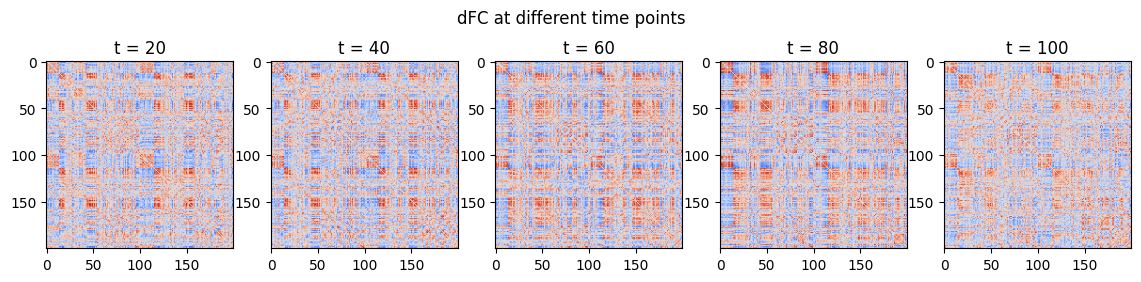

In [29]:
from comet import connectivity, utils
from matplotlib import pyplot as plt

sw = connectivity.SlidingWindow(time_series)
dfc = sw.estimate()

# Plot
fig, ax = plt.subplots(1, 5, figsize=(14, 3))
fig.suptitle("dFC at different time points")
for i in range(5):
    ax[i].imshow(dfc[:,:,(1+i)*20], cmap="coolwarm", vmin=-1, vmax=1)
    ax[i].set_title(f"t = {(1+i)*20}")

Fractional occupancy (mean ± sd):
 [0.057 0.165 0.21  0.278 0.29 ] ± [0. 0. 0. 0. 0.]
Mean transition matrix:
 [[0.3   0.2   0.2   0.2   0.1  ]
 [0.    0.552 0.138 0.138 0.172]
 [0.027 0.081 0.595 0.135 0.162]
 [0.02  0.061 0.082 0.673 0.163]
 [0.1   0.1   0.08  0.1   0.62 ]]


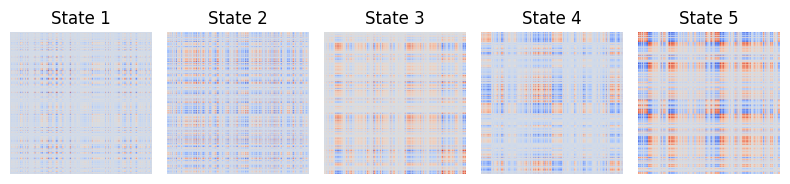

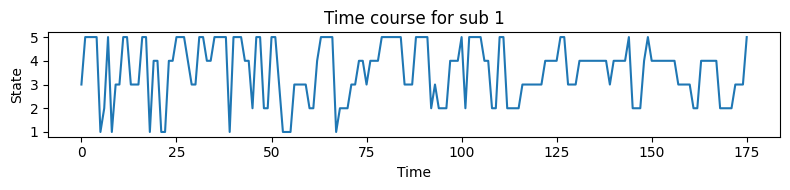

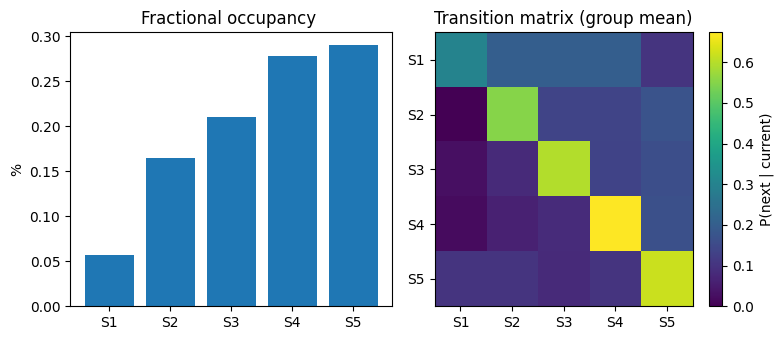

In [28]:
import numpy as np

ksvd = connectivity.KSVD(time_series)
state_tc, states = ksvd.estimate()

# Plot states and state time course
fig1, ax1 = utils.state_plots(states=states, figsize=(8,2))
fig2, ax2 = utils.state_plots(state_tc=state_tc, figsize=(8,2))

# Summarise the results
summary = utils.summarise_state_tc(state_tc)

# Print the summary statistics
dwell_mean = summary["fractional_occupancy"].mean(axis=0)
dwell_std = summary["fractional_occupancy"].std(axis=0)
trans_mean = summary["transitions"].mean(axis=0)

print("Fractional occupancy (mean ± sd):\n", np.round(dwell_mean, 3), "±", np.round(dwell_std, 3))
print("Mean transition matrix:\n",  np.round(trans_mean, 3))

# Plot summary statistics
summary = utils.summarise_state_tc(state_tc)
fig3, ax3 = utils.state_plots(summary=summary, figsize=(8,3.5))